In [1]:
import numpy as np
import math
from math import pi
from matplotlib import pyplot as plt

import qiskit
from qiskit import QuantumCircuit, transpile,  assemble
from qiskit_aer import AerSimulator

from qiskit.visualization import *

from qiskit import ClassicalRegister, QuantumRegister, transpile
#from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
#from qiskit import BasicAer

from qiskit.quantum_info.operators import Operator, Pauli

import qiskit_ibm_provider
import qiskit.quantum_info as qi

import itertools
from itertools import combinations

from qiskit import *

# Need gate classes for generating the Pauli twirling sets
from qiskit.circuit.library import (IGate, XGate, YGate, ZGate,
                                    CXGate, CZGate, ECRGate, iSwapGate,QFT, RYGate, RZGate)

# Classes for building up a directed-acyclic graph (DAG) structure
from qiskit.circuit import QuantumRegister,Parameter, ParameterVector, CircuitInstruction
from qiskit.dagcircuit import DAGCircuit

# Transpiler stuff needed to make a pass and passmanager
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.passes import Optimize1qGatesDecomposition,CommutativeCancellation,CXCancellation,Optimize1qGatesSimpleCommutation

In [4]:
angles_from_vqe =[-0.16729982, -0.14512247, -0.0918286 ]

In [3]:
nQ = 6 # nq needs to be even
m = 0.5
g = math.sqrt(m*16/3)

## Initialize Vacuum

In [ ]:
# prototype. activate nl links in the middle of the circuit

def activate(nl, nq = nQ, cir = None):
    if nq <= nl: raise Exception (" Size of system needs to be bigger than the number of links being activated. ")
    if cir == None: cir = QuantumCircuit(nq)
    loc = (nq-nl) // 2
    for i in range(nl):
        cir.x(loc+i)
    return cir

In [ ]:
# apply the VQE that initialize the circuit into true vacuum to circuit

def true_vac(angles = angles_from_vqe, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    
    return cir

## Construct Hamiltonian for QC

In [ ]:
def exp_hkin_even(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    for i in range(nq//2): # odd sites go to x basis
        cir.h(2*i+1)    
    # things
    for i in range(nq//2): # odd sites go to x basis
        cir.h(2*i+1)   
    return cir

def exp_hkin_odd(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    for i in range(nq//2): # even sites go to x basis
        cir.h(2*i)    
    # things
    for i in range(nq//2): # even sites go to x basis
        cir.h(2*i)
    return cir

In [9]:
def exp_hm(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    for i in range(nq):
        cir.cx(i, (i+1)%nq)
        cir.rz(-m*t, (i+1)%nq)
        cir.cx(i, (i+1)%nq)
    return cir

In [5]:
def exp_he(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    for i in range(nq):
        cir.rz(-3*t*g**2/8,i)
    return cir

### Tests

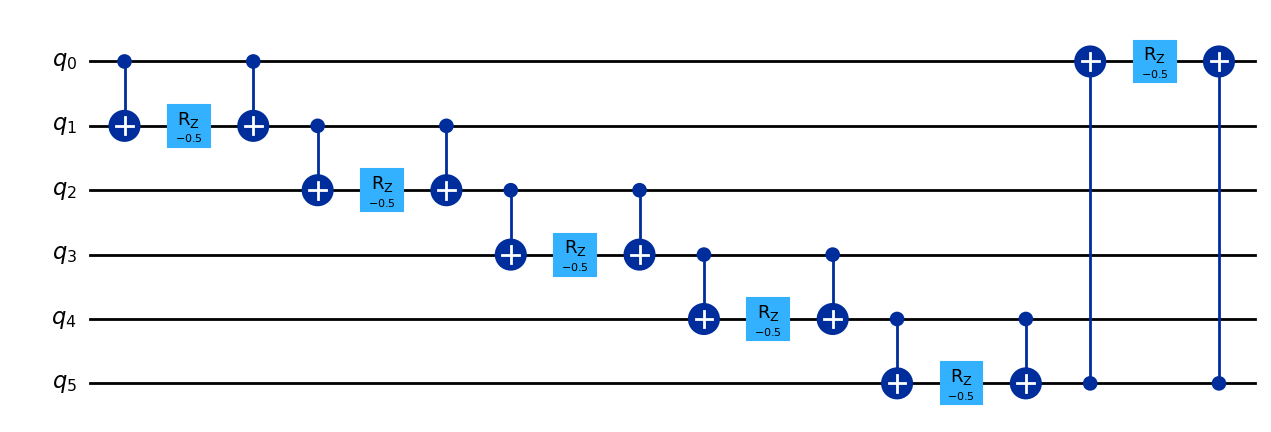

In [11]:
HM_cir = exp_hm(1)
HM_cir.draw('mpl')

In [6]:
HE_cir = exp_he(1)

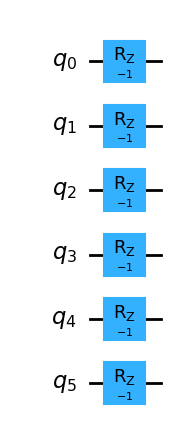

In [8]:
HE_cir.draw('mpl')

## Time Evolution

In [ ]:
def trotter_step(dt, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    exp_hkin_odd(dt/2, nq, cir) # can save cost by preconstructing kin_odd and kin_even and do cir.compose(kin_odd)
    exp_hkin_even(dt/2, nq, cir) # leaving as is for now until it is required to save compilation time
    exp_hm(dt, nq, cir)
    exp_he(dt, nq, cir)
    exp_hkin_even(dt/2, nq, cir)
    exp_hkin_odd(dt/2, nq, cir)
    return cir

In [ ]:
def time_ev(dt,steps, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    for i in range(steps):
        trotter_step(dt, nq, cir)
    return cir

# Run